In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [2]:
use_cuda = True
device = torch.device('cuda:3' if use_cuda else 'cpu')

# 1. load data

In [3]:
dataMNIST_train = dsets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
       ])
)
dataMNIST_test = dsets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
       ])
)

In [4]:
dataLoaderMNIST_train = torch.utils.data.DataLoader(
    dataset = dataMNIST_train,
    batch_size = 128,
    shuffle = True,
)
dataLoaderMNIST_test = torch.utils.data.DataLoader(
    dataset = dataMNIST_test,
    batch_size = 128,
    shuffle = True,
)

In [5]:
x,y = iter(dataLoaderMNIST_train).next()

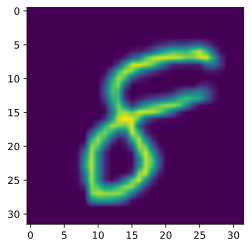

In [6]:
plt.imshow(x[0][0],interpolation = 'bilinear')

# 2. VAE model

In [7]:
class VAE(nn.Module):
    def __init__(self, inputChannel = 1, featureSize = 32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            #(32,32)
            nn.Conv2d(1,16,3,stride = 2,padding = 1),#(16,16)
            nn.ReLU(),
            nn.Conv2d(16,32,3,stride = 2,padding = 1),#(8,8)
            nn.ReLU(),
            nn.Conv2d(32,64,3,stride = 2,padding = 1),#(4,4)
            nn.ReLU(),
            nn.Conv2d(64,128,3,stride = 2,padding = 1),#(2,2)
            nn.ReLU(),
            nn.Conv2d(128,256,3,stride = 2,padding = 1),#(1,1)
            nn.ReLU(),
        )
        
        self.fc_mean = nn.Conv2d(256,32,1)
        self.fc_logvar = nn.Conv2d(256,32,1)
        self.fc_decoder = nn.Conv2d(32,256,1)
        
        self.decoder = nn.Sequential(
            #(1,1)
            nn.ConvTranspose2d(256,128,4,stride = 2,padding = 1),#(2,2)
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,stride = 2,padding = 1),#(4,4)
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,stride = 2,padding = 1),#(8,8)
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,4,stride = 2,padding = 1),#(16,16)
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,4,stride = 2,padding = 1),#(32,32)
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn(std.size()).cuda(device)
        z = mean + eps*std
        return z
    
    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = self.fc_mean(h), self.fc_logvar(h)
        z = self.reparameterize(mean,logvar)
        return z, mean, logvar
    
    def decode(self, z):
        x = self.fc_decoder(z)
        y = self.decoder(x)
        return y
        
    def forward(self, x):
        z, mean, logvar = self.encode(x)
        y = self.decode(z)
        return y, z, mean, logvar

In [8]:
vae = VAE()
vae.to(device)
x,y = iter(dataLoaderMNIST_train).next()

In [9]:
y_, z, mean, logvar = vae(x[0:1].cuda(device))
y.shape

torch.Size([128])

In [10]:
optimizer = optim.Adam(vae.parameters(),lr = 0.01)

In [11]:
vae.train()
for i in range(5):
    for step,(x,y) in enumerate(dataLoaderMNIST_train):
        x = x.cuda(device)
        y_, z, mean, logvar = vae(x)
        
        KLD_loss = -0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar)) # KL divergence
        
        Bernoulli_MLP_loss = F.binary_cross_entropy(y_, x, reduction='sum') # BCE
        
#         Gaussian_MLP_loss = 
        
        loss = KLD_loss + Bernoulli_MLP_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print('\r epoch:{epoch:3}--step:{step:5}--loss:{loss:.7f}'.format(epoch=i,step=step,loss=loss),end='')
    print()
    

 epoch:  0--step:  468--loss:18794.2109375
 epoch:  1--step:  468--loss:18919.2753906
 epoch:  2--step:  468--loss:18664.1464844
 epoch:  3--step:  468--loss:16588.0585938
 epoch:  4--step:  468--loss:17385.6250000


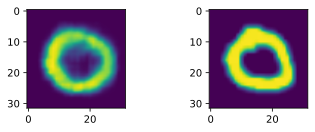

In [18]:
plt.subplot(221).imshow(y_[10][0].cpu().detach().numpy(),interpolation = 'bilinear')
plt.subplot(222).imshow(x[10][0].cpu().detach().numpy(),interpolation = 'bilinear')